In [1]:
with open('./function/requirements_import.py') as f:
    exec(f.read())
    
from datetime import datetime
import scipy.stats as stats
from scipy.stats import spearmanr

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostClassifier, Pool
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )

In [2]:
file_path = './data/rainfall_train_v3.csv'
rainfall = pd.read_csv(file_path)

In [36]:
rainfall['pred_YN'].value_counts()

pred_YN
1    1346330
0     106390
Name: count, dtype: int64

In [3]:
# rainfall

# 변수생성

In [4]:
temp = rainfall.loc[:, ['fc_year', 'fc_month', 'fc_day', 'fc_hour', 'stn4contest'] + [f'v0{i}' for i in range(1,10)]]

temp[['fc_year']] = temp[['fc_year']].replace({'A': 2021, 'B': 2022, 'C': 2023}) #임시값
temp['datetime'] = temp.apply(lambda row: datetime(int(row['fc_year']), int(row['fc_month']), int(row['fc_day']), int(row['fc_hour'])), axis=1)

temp['Weekday'] = pd.to_datetime(temp['datetime']).dt.weekday
temp['IsWeekend'] = temp['Weekday'] >= 5

col = [f'v0{i}' for i in range(1,10)]
col1 = ['fc_year', 'fc_month', 'fc_day', 'fc_hour', 'stn4contest', 'Weekday', 'IsWeekend']
col2 = ['y', 'm', 'd', 'h', 'aws', 'w', 'isw']

for a,b in zip(col1, col2):
    for val in col:
        dic = temp.groupby(a)[val].mean().to_dict()
        temp[f'{b}_{val}'] = temp[a].map(dic)
        
for val in col:
    temp[f'diff_{val}'] = rainfall[val].diff()
    result = seasonal_decompose(rainfall[val], model='additive', period=80)
    temp[f't_{val}'] = result.trend
    temp[f's_{val}'] = result.seasonal
    temp[f'r_{val}'] = result.resid

In [5]:
# temp.iloc[:3]

In [6]:
temp2 = pd.concat([rainfall, temp.loc[:, temp.columns[15:]]], axis=1)
temp2 = temp2.iloc[80:-80, :]
temp2 = temp2.reset_index(drop=True)
print(temp2.shape)

# for val in temp2.columns:
#     print(val)

(1452560, 134)


In [7]:
temp = temp2.drop(columns=['fc_year', 'stn4contest', 'class_interval', 'pred', 'pred_YN', 'Weekday', 'IsWeekend'])
print(temp.shape)
# 상관계수 행렬 계산
corr_matrix = temp.corr().abs()

# 상관계수가 0.99 이상인 변수 쌍 찾기
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

# 변수 제거
temp2_rdc = temp.drop(columns=to_drop)
print(temp2_rdc.shape)

(1452560, 127)
(1452560, 82)


## 변수 중요도

In [8]:
# 예제 데이터 생성
col1 = ['pred', 'Weekday', 'IsWeekend']
target = 'class_interval'

x = pd.concat([temp2_rdc, temp2.loc[:, col1]], axis=1)
y = temp2.loc[:, target]

In [9]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(x, y)
scores = selector.scores_

# 특징과 점수를 묶어 리스트로 만들고 점수를 기준으로 정렬
features_scores = sorted(zip(x.columns, scores), key=lambda x: x[1], reverse=True)
feature = [val for i, (val, num) in enumerate(features_scores) if num>=10000]

# 중요 특징 출력
# for fea, score in features_scores:
#     print(f"Feature: {fea}, Score: {score:.4f}")
    
len(feature)

26

In [10]:
aa, bb = idx_find(temp2_rdc)
print(aa, bb)

871439 1234559


In [11]:
y.value_counts()

class_interval
0.0    1220857
5.0      42378
2.0      36368
4.0      33948
3.0      31403
6.0      28225
1.0      23069
7.0      21181
8.0       8172
9.0       6959
Name: count, dtype: int64

In [12]:
ind_class = [np.where(y == i)[0] for i in range(10)]
min_samples = 8172 #min(len(indices) for indices in ind_class)

# 각 범주에서 최소 데이터 수만큼 랜덤 샘플 추출
bal_ind = np.hstack([np.random.choice(indices, min_samples, replace=False) if i<9 else np.random.choice(indices, 6959, replace=False) for i, indices in enumerate(ind_class)])

# 추출한 인덱스로 데이터와 레이블 준비
x_fea = x[feature]
num = len(feature)
gaf = GramianAngularField(method='summation')
x_gaf = gaf.fit_transform(x_fea)
x_gaf4 = x_gaf.reshape(-1, num, num, 1)

bal_x = x_gaf4[bal_ind]
bal_y = y[bal_ind]

In [13]:
# 7:1.7:1.3 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(bal_x, bal_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

x_train = x_train/255.
x_val = x_val/255.
x_test = x_test/255.

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48713, 26, 26, 1) (12526, 26, 26, 1) (8351, 26, 26, 1)
(48713,) (12526,) (8351,)


In [37]:
from tensorflow.keras.constraints import max_norm
clear_session()

model = Sequential([Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu', input_shape=x_train.shape[1:]),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )
lr_sch = LearningRateScheduler(scheduler)
# 학습
history = model.fit(x_train, y_train, epochs = 100, callbacks=[lr_sch], validation_data=(x_val, y_val)).history #, callbacks=[es]

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       346,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,114 (1.32 MB)

 Trainable params: 347,114 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1290 - loss: 2.2995 - val_accuracy: 0.1586 - val_loss: 2.2837 - learning_rate: 3.6788e-05
Epoch 2/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1614 - loss: 2.2731 - val_accuracy: 0.1617 - val_loss: 2.2530 - learning_rate: 3.3287e-05
Epoch 3/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1700 - loss: 2.2408 - val_accuracy: 0.1690 - val_loss: 2.2295 - learning_rate: 3.2956e-05
Epoch 4/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1759 - loss: 2.2175 - val_accuracy: 0.1764 - val_loss: 2.2131 - learning_rate: 3.2923e-05
Epoch 5/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - accuracy: 0.1806 - loss: 2.2014 - val_accuracy: 0.1755 - val_loss: 2.2010 - learning_rate: 3.2920e-05
Epoch 6/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.1818 - loss: 2.1898 - val_accuracy: 0.1735 - val_loss: 2.1922 - learning_rate: 3.2919e-05
Epoch 7/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

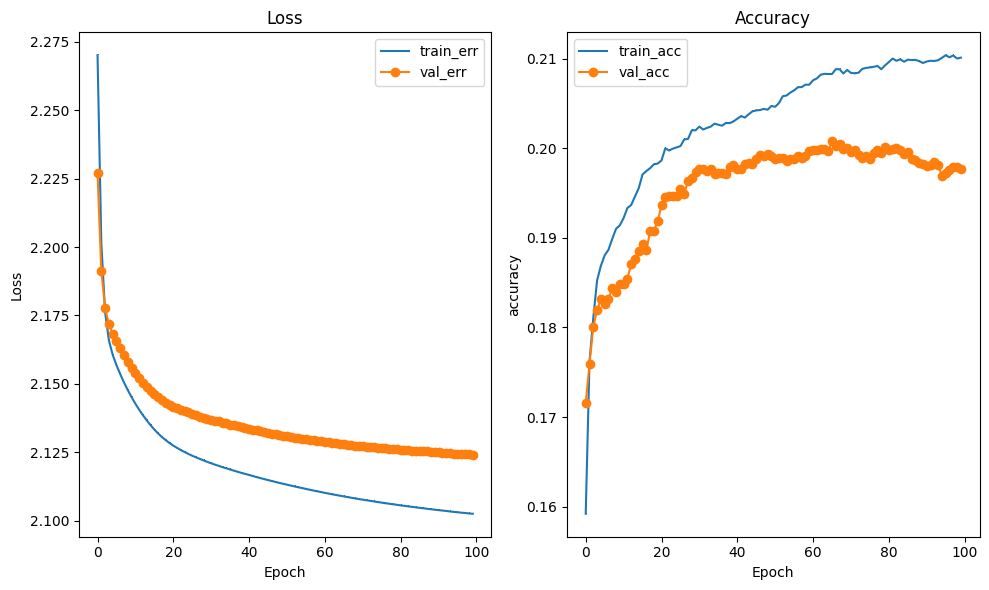

In [21]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [27]:
model2 = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val)).history

Epoch 1/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2140 - loss: 2.0957 - val_accuracy: 0.2014 - val_loss: 2.1212
Epoch 2/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.2141 - loss: 2.0956 - val_accuracy: 0.2017 - val_loss: 2.1211
Epoch 3/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.2141 - loss: 2.0956 - val_accuracy: 0.2015 - val_loss: 2.1211
Epoch 4/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.2140 - loss: 2.0956 - val_accuracy: 0.2015 - val_loss: 2.1211
Epoch 5/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.2140 - loss: 2.0955 - val_accuracy: 0.2016 - val_loss: 2.1211
Epoch 6/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.2140 - loss: 2.0955 - val_accuracy: 0.2015 - val_loss: 2.1211
Epoch 7/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.2139 - loss: 2.0955 - val_accuracy: 0.2014 - val_loss: 2.1211
Epoch 8/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 

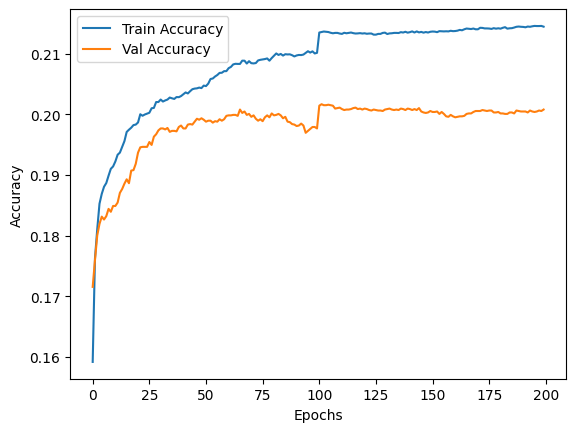

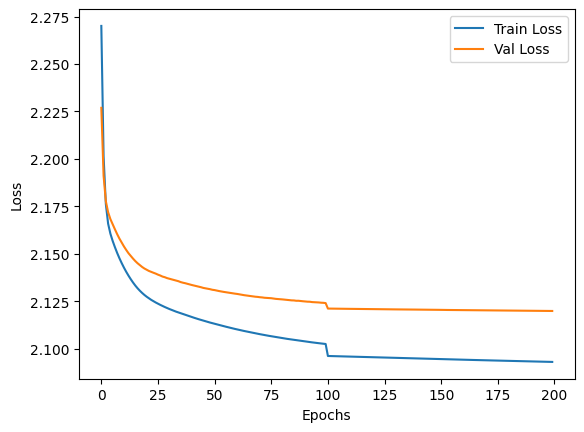

In [33]:
total_acc = history['accuracy'] + model2['accuracy']
total_val_acc = history['val_accuracy'] + model2['val_accuracy']
total_loss = history['loss'] + model2['loss']
total_val_loss = history['val_loss'] + model2['val_loss']

plt.plot(total_acc, label='Train Accuracy')
plt.plot(total_val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(total_loss, label='Train Loss')
plt.plot(total_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

----

In [ ]:
joblib.dump(lis_srt, './data/lis_srt.pkl')
lis_srt = joblib.load('./data/lis_srt.pkl')

In [ ]:
col2 = [x[1] for x in lis_srt if x[0]>=0.5]

x = temp.drop(columns=[target])
x = temp.loc[:, col2]

y = temp.loc[:, target]

# 데이터 분할
aa, bb = idx_find(temp)

x_train = x.iloc[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x.iloc[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x.iloc[bb+1:]
y_test = y.iloc[bb+1:]

In [34]:
# CatBoost 모델 학습
model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=10, verbose=0, random_state=42)
train_pool = Pool(x_train, y_train)
eval_pool = Pool(x_test, y_test)

# 모델 학습 및 학습 과정 기록
model.fit(train_pool, eval_set=eval_pool, plot=True)
print(model.get_best_score())

# 학습곡선 출력
plt.show()


CatBoostError: Input data has invalid shape: (48713, 26, 26, 1). Must be 2 dimensional

0.8965504587155964
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97    191600
         1.0       0.00      0.00      0.00      2947
         2.0       0.33      0.06      0.10      5365
         3.0       0.33      0.13      0.19      3567
         4.0       0.21      0.16      0.18      3578
         5.0       0.29      0.25      0.27      4711
         6.0       0.39      0.28      0.32      2655
         7.0       0.41      0.22      0.29      2088
         8.0       0.39      0.14      0.20       735
         9.0       0.46      0.14      0.22       754

    accuracy                           0.90    218000
   macro avg       0.37      0.24      0.27    218000
weighted avg       0.85      0.90      0.87    218000



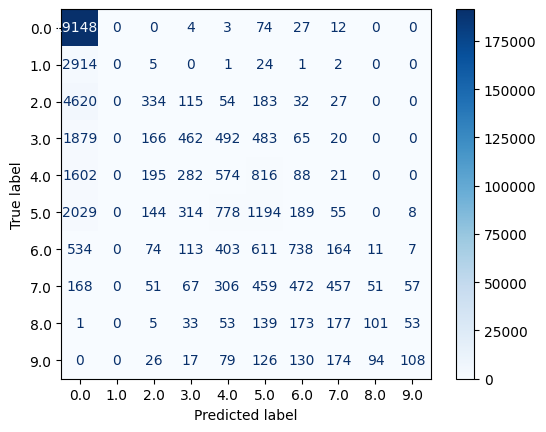

In [ ]:
accuracy = model.score(x_test, y_test)
print(accuracy)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# 오분류표 히트맵
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot(cmap='Blues')

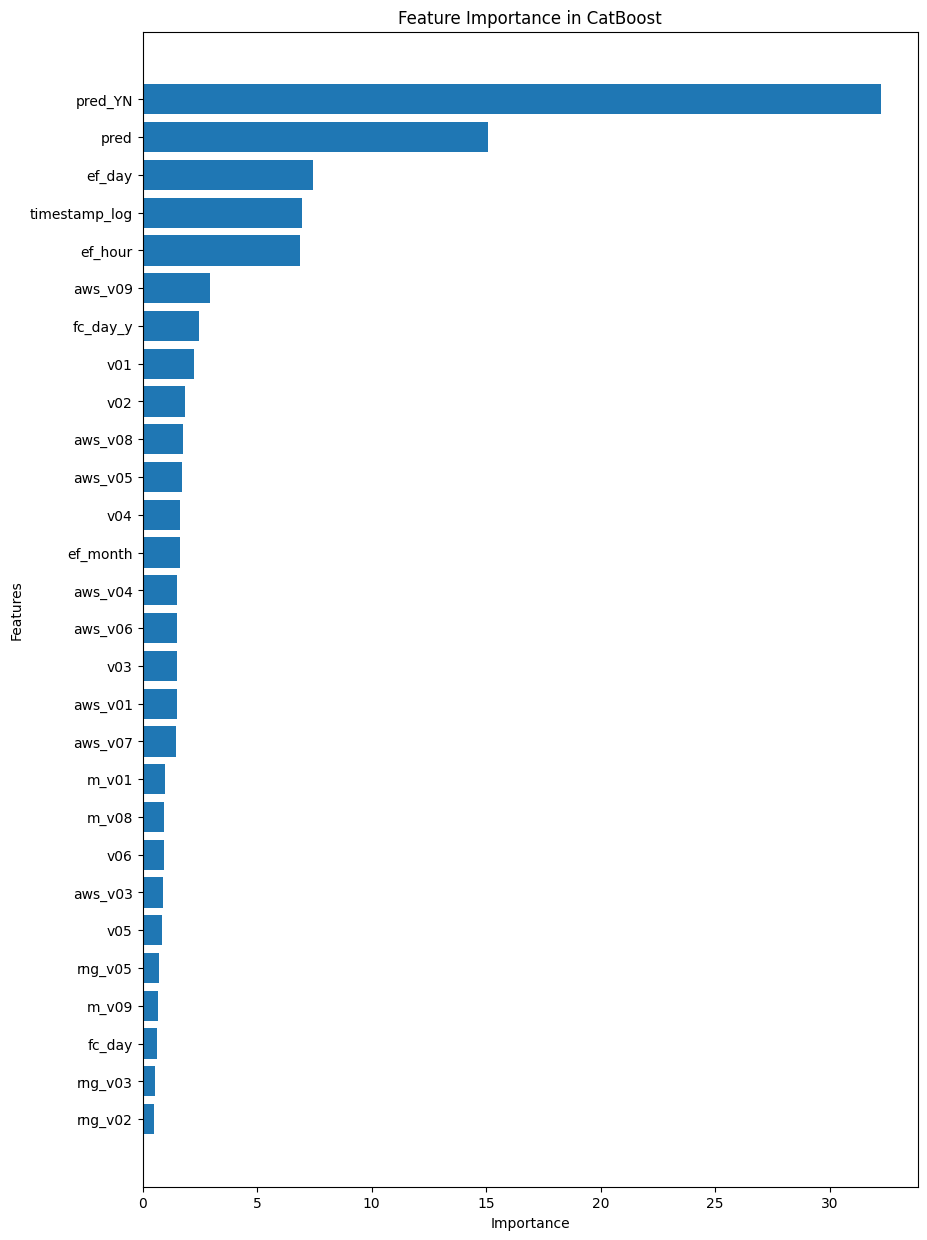

28 -->  28


In [ ]:
# 변수 중요도 확인
feature_importance = model.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()

result = []
for val, key in lis_srt:
    if val > 0:
        result.append(key)
        
print(len(lis_srt), '--> ', len(result))

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {"iterations": [100,200,300],
          'learning_rate':[0.1,0.01,0.001],
          'depth':[5,10,20]}

# 모델생성
dt = CatBoostClassifier(random_state=42)

# AutoML모델 생성
gs = GridSearchCV(dt, param_grid=params, n_jobs=-1, cv=5)

# AutoML모델 훈련
gs.fit(x_train, y_train)

# 찾은 최적모델 사용
dt = gs.best_estimator_
dt.get_best_score()

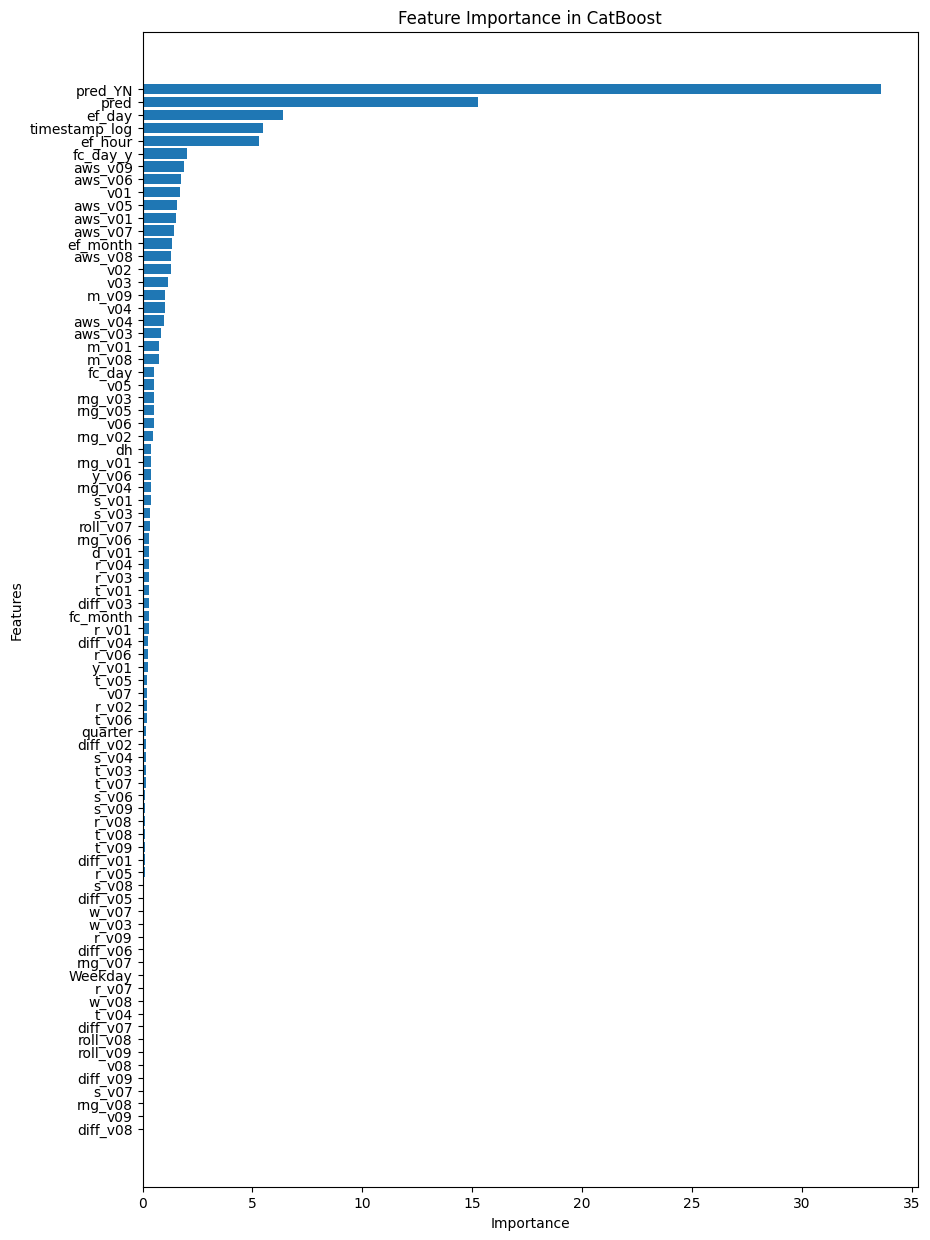

In [ ]:
# 변수 중요도 확인
feature_importance = model.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()


In [ ]:
# 변수 중요도 확인
feature_importance = model2.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()


In [ ]:
print(len(lis_srt))
result = []
for val, key in lis_srt:
    if val > 0:
        result.append(key)
        
len(result)

In [ ]:
# temp = temp2.loc[:, result + ['class_interval']]
# temp
temp.to_csv('./data/rainfall_train_v4_eda2.csv', index=False)

In [ ]:
a = temp.isnull().sum().to_dict()

for val, i in a.items():
    if i>0:
        print(val)

In [ ]:
# CatBoost 모델 학습
model = CatBoostClassifier(iterations=200, learning_rate=.1, depth=12, early_stopping_rounds=30, verbose=10, random_state=42)
train_pool = Pool(x_train, y_train)
eval_pool = Pool(x_test, y_test)

# 모델 학습 및 학습 과정 기록
model.fit(train_pool, eval_set=eval_pool, plot=True, use_best_model=True)
print(model.get_best_score())

# 학습곡선 출력
plt.show()

0.8796926605504587
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94    191600
         1.0       0.00      0.00      0.00      2947
         2.0       0.00      0.00      0.00      5365
         3.0       0.00      0.00      0.00      3567
         4.0       0.06      0.00      0.00      3578
         5.0       0.21      0.03      0.06      4711
         6.0       0.19      0.04      0.07      2655
         7.0       0.21      0.05      0.09      2088
         8.0       0.07      0.00      0.00       735
         9.0       0.39      0.04      0.07       754

    accuracy                           0.88    218000
   macro avg       0.20      0.12      0.12    218000
weighted avg       0.79      0.88      0.83    218000



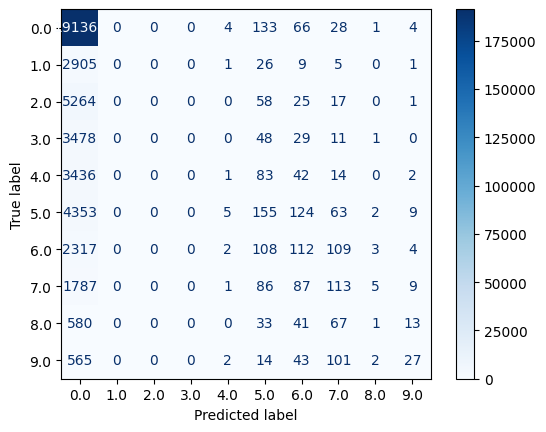

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

accuracy = model.score(x_test, y_test)
print(accuracy)


y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# 오분류표 히트맵
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot(cmap='Blues')